In [21]:
from models import *
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
from random import random

print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)

excel_reports = ".\Excel reports"
saved_models = ".\Saved models"
trained_models = ".\Trained models"
tested_models = ".\Tested models"
temp = ".\Temp"

# Initiate parameters
ticker = 'tsla'
period = "1wk" 
shuffle = True

api_key = '631505e804ec58.42743136'


# Sentiment types... APISentiment	VaderSentiment	CombinedVaderSentiment RobertaLargeSentiment #TwitterSentiment
sentiment = True
sentiment_type = 'CombinedVaderSentiment'
aggr_function = 'median'

formation_window = 3
target_window = 1

#Split Ratios
split_ratio = 0.70
test_ratio = 0.15
validation_ratio = 0.15
export_excels = False

#trade condition
condition = False

# EMA indicators
indicator1 = 5
indicator2 = 8
indicator3 = 21

# Period model is trained and tested
start_date = '2018-01-01'  
end_date = '2023-02-12'  

# Do not change
window_size = formation_window + 1

# training batches
batch_size_train = 6
batch_size_valid = 2

if sentiment == False:
    news_df = None
if sentiment_type == 'TwitterSentiment':
    twitter = True
else:
    twitter = False
    
# Print stuffs
print("\nwindow size: ", window_size)
print("formation_window: ", formation_window)
print("target_window: ", target_window)
print("chart period: ", period)


# #Delete folders
# shutil.rmtree(excel_reports)
# shutil.rmtree(saved_models)
# shutil.rmtree(trained_models)
# shutil.rmtree(tested_models)
# shutil.rmtree(temp)

# Create folder, if exist pass exception
try:
    os.mkdir("Excel reports")
    os.mkdir("Saved models")
    os.mkdir("Trained models")
    os.mkdir("Tested models")
    os.mkdir("Temp")
except:
    pass


Tensorflow version:  2.9.1
Numpy version:  1.23.1

window size:  4
formation_window:  3
target_window:  1
chart period:  1wk


In [22]:
if sentiment == True:

    from sentiment import GetNews

    GetNewsAPI = GetNews()

    GetNewsAPI.fit(ticker=ticker, start_date=start_date, end_date=end_date,
                   n_news=1000, token=api_key, offset=0, export_excel=True, twitter=twitter)
    news_df = GetNewsAPI.transform()
#news_df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\z0040jeb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\z0040jeb\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


--------> GetNews completed



In [23]:
from transformers_preprocess import PullData

GetData = PullData()

print("ticker: ",ticker)

GetData.fit(ticker=ticker,
            start_date=start_date,
            end_date=end_date,
            interval=period,  # 1wk
            progress=False,
            condition=condition,
            form_window=formation_window,
            target_window=target_window,
            timeperiod1=indicator1,#6
            timeperiod2=indicator2,#12
            timeperiod3=indicator3,#24
            export_excel=export_excels,
            excel_path=excel_reports,
            listed_conditions=None,
            sentiment=sentiment,
            sentiment_type=sentiment_type, #sentiment_type
            news_df=news_df,
            chart_period=period,
            sentiment_aggr=aggr_function,
            )

data_prep = GetData.transform()

# Validation
if window_size != (formation_window + 1):
    raise Exception(
        f"Error - window_size ({window_size}) must be equal to sum of formation_window ({formation_window}) and value 1.")
data_prep.tail(8)


ticker:  tsla
initial shape:  (268, 6)


,Date,Open,High,Low,Close,EMA5,EMA8,EMA21,CombinedVaderSentiment,trades
262,2023-01-09 00:00:00,118.959999,125.949997,114.919998,122.400002,131.275703,145.147877,189.537272,0.0000,263
263,2023-01-16 00:00:00,125.699997,136.679993,124.309998,133.419998,131.990468,142.541682,184.435702,0.2020,263
264,2023-01-23 00:00:00,135.869995,180.679993,134.270004,177.899994,147.293644,150.399084,183.841547,0.5321,263
0,Month,178.050003,199.000000,162.779999,189.979996,131.990468,142.541682,184.435702,0.2020,263
263,2023-01-16 00:00:00,125.699997,136.679993,124.309998,133.419998,131.990468,142.541682,184.435702,0.2020,264
264,2023-01-23 00:00:00,135.869995,180.679993,134.270004,177.899994,147.293644,150.399084,183.841547,0.5321,264
265,2023-01-30 00:00:00,178.050003,199.000000,162.779999,189.979996,161.522428,159.194842,184.399587,0.4220,264
0,Month,193.009995,214.000000,189.550003,196.889999,161.522428,159.194842,184.399587,0.4220,264


In [24]:
####################################################################

from transformers_preprocess import NormalizeData

NormalizeData = NormalizeData()

NormalizeData.fit(window_size=window_size, shuffle=shuffle, debug=False,
                  export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment)

data_normalized, Dates = NormalizeData.transform(data_prep)
data_normalized.head(8)
# Get only forecasts for model testing
# x_valid_x = data_normalized[['maxv','minv']].copy() #extreme values for reverting normalization
# x_valid = data_normalized.iloc[:,:-2].copy() #dataset for forecast
#Dates



Dataframe shape:  (1056, 10)
Number of formations:  264
--------> NormalizeData completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,CombinedVaderSentiment,maxv,minv
0,0.547099,0.653775,0.284701,0.633546,0.322506,0.156870,0.000000,0.0,25.299334,20.718497
1,0.663089,0.814590,0.214990,0.219066,0.288026,0.170691,0.019915,0.0,25.299334,20.718497
2,0.206986,0.594106,0.206986,0.577806,0.384619,0.261161,0.070632,0.0,25.299334,20.718497
3,0.716355,1.000000,0.581881,0.686811,0.288026,0.170691,0.019915,0.0,25.299334,20.718497
4,0.611988,0.842768,0.401477,0.743159,0.728876,0.795929,0.895070,0.0,21.122667,16.518000
5,0.734183,0.972781,0.185174,0.246127,0.567960,0.673751,0.836075,0.0,21.122667,16.518000
6,0.839728,1.000000,0.177067,0.205299,0.447073,0.569650,0.778731,0.0,21.122667,16.518000
7,0.242508,0.289417,0.000000,0.159404,0.567960,0.673751,0.836075,0.0,21.122667,16.518000


In [25]:
####################################################################

from training import SplitData

SplitData = SplitData()

SplitData.fit(split_ratio=split_ratio, window_size=window_size,
              dates=Dates, debug=False, export_excel=export_excels, excel_path=excel_reports, sentiment=sentiment,validation_set=validation_ratio, test_set=test_ratio)

x_train, x_valid, x_test, x_train_x, x_valid_x, x_test_x,_ = SplitData.transform(data_normalized)
# x_train.head(25)



DF Shape:  (1056, 10)
train_split split:  740
validation split:  160
total validation windows:  79.0

Split train ratio: 70 %
Split validation ratio: 15 %
Split test ratio: 15 %

train period: 2018-11-12 - 2021-08-30
valid period: 2019-05-06 - 2020-02-03
test period: 2021-10-18 - 2022-12-19

Total Windows:  264.0
x_train windows:  185.0
x_valid windows:  40.0
x_test windows:  39.0
--------> SplitData completed



In [26]:
from training import GetTensoredDataset

GetTensoredDataset = GetTensoredDataset()

GetTensoredDataset.fit(window_size=window_size, batch_size=batch_size_train, train=True, debug=False)

x_train_tensors, _ = GetTensoredDataset.transform(x_train)

# c = 0
# for batch in x_train_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed



In [27]:
from training import GetTensoredDataset

GetTensoredValidDataset = GetTensoredDataset()

GetTensoredValidDataset.fit(
    window_size=window_size, batch_size=batch_size_valid, train=False, debug=False)

x_valid_tensors, labels_valid = GetTensoredValidDataset.transform(x_valid)
x_test_tensors, labels = GetTensoredValidDataset.transform(x_test)
# for batch in x_valid_tensors:
#     if c < 3:
#         print(batch)
#     else:
#         break


--------> GetTensoredDataset completed

--------> GetTensoredDataset completed



<b>Model Training</b>

In [28]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

datetime_ = datetime.today().date()
number = int(random()*10000)
model_name_ = f'{ticker}_model_{datetime_}_{number}.h5'
model_name = f'{saved_models}/{model_name_}'

metric = 'loss'
early_stopping = EarlyStopping(
    monitor=metric, patience=6, mode='min', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor=metric, factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=0)

model_checkpoint = ModelCheckpoint(monitor=metric,
                                   filepath=model_name,
                                   save_best_only=True)

callbacks = [early_stopping, reduce_lr, model_checkpoint]


def sign_penalty(y_true, y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred, 0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                    )

    return(tf.reduce_mean(loss, axis=-1))


tf.keras.losses.sign_penalty = sign_penalty


Bellow code is used to find the best model architecture, recommended to use cloud computing

In [29]:
# from testing import get_models,optimize
# from datetime import datetime
# start_time = datetime.now().strftime("%H:%M:%S")
# start = datetime.now()
# print("Training started at ",start_time)
# tf.random.set_seed(7788)
# np.random.seed(7788)

# # #Permutation testing
# # num_layers = 2
# # min, max = 2, 4
# # node_step_size = 2
# # node_options = list(range(min, max + 1, node_step_size))
# # two_layer_possibilities = [node_options, node_options]
# # layer_node_permutations  = list(itertools.product(*two_layer_possibilities))

# f_df = pd.DataFrame()

# for layer in range(5,6):
#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("\n------ > Layer: ",layer)
#     print("Layer loop started: ",progress_time)

#     all_models, names = get_models(num_layers=layer, min=2, max=4, node_step_size=2, features=x_train.shape[1])

#     progress_time = datetime.now().strftime("%H:%M:%S")
#     print("Models: ",len(all_models))
#     print("Models constructed: ",progress_time)
    
#     optimizing_df = optimize(models=all_models,X_train=x_train_tensors,X_valid=x_valid_tensors,X_test=x_valid,labels=labels_valid,epochs=1000,verbose=0,window_size=window_size,callbacks=callbacks,layer=layer,ticker=ticker,excel_path=tested_models)
# # optimizing_df
#     f_df = f_df.append(optimizing_df)
#     f_df.to_excel('test.xlsx')
# end_time = datetime.now().strftime("%H:%M:%S")
# end = datetime.now()
# print("\nTraining ended at ",end_time) 
# print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")

Get Model

In [30]:
from datetime import datetime
start_time = datetime.now().strftime("%H:%M:%S")
start = datetime.now()
print("Training started at ",start_time)

tf.random.set_seed(7788)
np.random.seed(7788)
features = x_train.shape[1]

print(f"Model training - {str.upper(ticker)} \n")
def general_model(features: int):
    model = tf.keras.models.Sequential([

        tf.keras.layers.Conv1D(filters=1, kernel_size=10,
                               strides=1, padding="same",
                               activation=tf.nn.selu,
                               input_shape=[None, features]),

        tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(3, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(3)),
        tf.keras.layers.Dense(4, activation=tf.nn.selu),
        tf.keras.layers.Dense(3, activation=tf.nn.selu),
        tf.keras.layers.Dense(2, activation=tf.nn.selu),
        tf.keras.layers.Dense(1, activation=tf.nn.relu),
    ])
    return model
    
model = general_model(features)


optimizer2 = tf.keras.optimizers.Adam(
            learning_rate=0.00007, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
optimizer5 = tf.keras.optimizers.Adagrad(
    learning_rate=0.0006, initial_accumulator_value=5, epsilon=1e-07, name='Adagrad')

model.compile(loss=sign_penalty,
              optimizer=optimizer2
              )

model.fit(x_train_tensors, epochs=1000, callbacks=[callbacks], validation_data=x_valid_tensors,verbose=1)


end_time = datetime.now().strftime("%H:%M:%S")
end = datetime.now()
print("\nTraining ended at ",end_time) 
print(f"Training ended in {round((end-start).total_seconds(),2)} seconds")



Training started at  23:06:39
Model training - TSLA 

Epoch 1/1000
31/31 [==============================] - 13s 85ms/step - loss: 0.5089 - val_loss: 0.3550 - lr: 7.0000e-05
Epoch 2/1000
31/31 [==============================] - 0s 10ms/step - loss: 0.4298 - val_loss: 0.2937 - lr: 7.0000e-05
Epoch 3/1000
31/31 [==============================] - 0s 11ms/step - loss: 0.3630 - val_loss: 0.2445 - lr: 7.0000e-05
Epoch 4/1000
31/31 [==============================] - 0s 11ms/step - loss: 0.3081 - val_loss: 0.2053 - lr: 7.0000e-05
Epoch 5/1000
31/31 [==============================] - 0s 10ms/step - loss: 0.2629 - val_loss: 0.1740 - lr: 7.0000e-05
Epoch 6/1000
31/31 [==============================] - 0s 10ms/step - loss: 0.2257 - val_loss: 0.1490 - lr: 7.0000e-05
Epoch 7/1000
31/31 [==============================] - 0s 11ms/step - loss: 0.1951 - val_loss: 0.1293 - lr: 7.0000e-05
Epoch 8/1000
31/31 [==============================] - 0s 13ms/step - loss: 0.1697 - val_loss: 0.1139 - lr: 7.0000e-05
E

In [31]:
from functions import model_forecast
forecast = model_forecast(model, x_test, window_size=window_size, debug=False)

from transformers_preprocess import ReverseNormalization

ReverseNormalization = ReverseNormalization()

ReverseNormalization.fit(forecasts=forecast, labels=labels,
                         x_test=x_test, x_test_x=x_test_x, window_size=window_size, debug=False,
                         sentiment=sentiment,sentiment_type=sentiment_type)

df = ReverseNormalization.transform()
df.head(8)


39/39 [==============================] - 2s 2ms/step
--------> ReverseNormalization completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,CombinedVaderSentiment
In,,,,,,,,,,
0,283.929993,303.333344,283.823334,303.226654,276.925378,267.198073,246.318221,NaN,NaN,0.0
1,316.843323,371.736664,314.733337,371.333344,308.394700,290.339244,257.683232,NaN,NaN,0.0
2,381.666656,414.496674,372.886658,407.363342,341.384247,316.344599,271.290515,NaN,NaN,0.0
3,383.263336,399.000000,329.103333,344.473328,308.394700,290.339244,257.683232,399.000000,401.236118,0.0
4,238.240005,247.330002,237.576660,244.523331,235.800421,232.023684,224.676647,NaN,NaN,0.0
5,246.666672,254.816666,244.839996,245.423340,239.008061,235.001385,226.562710,NaN,NaN,0.0
6,246.736664,253.679993,236.283340,253.163330,243.726484,239.037373,228.980948,NaN,NaN,0.0
7,244.853333,258.266663,239.539993,258.130005,239.008061,235.001385,226.562710,258.266663,253.368458,0.0


In [32]:
from final_evaluation import GetFinalDataframe

GetFinalDataframe = GetFinalDataframe()

GetFinalDataframe.fit(dates=Dates,
                      x_test=x_test,
                      sentiment=sentiment,
                      sentiment_type=sentiment_type)

reversed_df = GetFinalDataframe.transform(df)
#reversed_df.head(10)


--------> GetFinalDataframe



In [33]:
from final_evaluation import GetModelPerformance
#print(f"Window size: {window_size} \n")
print(f"ticker: {str.upper(ticker)}\n")
GetModelPerformance = GetModelPerformance()

acceptance = 0
penalization = 0

GetModelPerformance.fit(acceptance=acceptance,
                        penalization=penalization,
                        entry_candle='Current Open',#Current Open
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports,
                        sentiment=sentiment)

trades_df = GetModelPerformance.transform(reversed_df)
#trades_df = trades_df.sort_values('Datetime',ascending=True)

#trades_df.tail(16)

ticker: TSLA

Formations:  39
period: 2021-10-18 - 2022-12-19
Entry Candle:  Current Open

Total Trades:  35
Profit Trades:  30
Loss Trades:  5

Win Ratio: 86.0 %
Loss Ratio: 14 %

Trade nr with exact TP:  21
Ratio of exact TP: 60.0 %

Average profit per trade:  598

Gross profit:  20943
Gross loss:  -3121

Net profit:  17822


In [20]:
trades_df[trades_df['profit']<0]

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,Datetime,profit,trade
In,,,,,,,,,,,,
0,283.929993,303.333344,283.823334,303.226654,276.925378,267.198073,246.318221,nn,nn,2021-10-18,-38.790009,1
1,316.843323,371.736664,314.733337,371.333344,308.394700,290.339244,257.683232,nn,nn,2021-10-25,-38.790009,1
2,381.666656,414.496674,372.886658,407.363342,341.384247,316.344599,271.290515,nn,nn,2021-11-01,-38.790009,1
3,383.263336,399.000000,329.103333,344.473328,308.394700,290.339244,257.683232,399.0,401.167743,2021-11-02,-38.790009,1
20,301.276672,313.606659,285.543335,288.170013,273.649549,266.889810,270.909618,nn,nn,2022-08-01,-3.823334,6
21,295.000000,305.200012,279.353333,300.029999,282.443032,274.254296,273.556925,nn,nn,2022-08-08,-3.823334,6
22,301.786682,314.666656,292.500000,296.666656,287.184240,279.234821,275.657810,nn,nn,2022-08-15,-3.823334,6
23,291.913330,303.646667,286.296661,288.089996,282.443032,274.254296,273.556925,303.646667,308.521324,2022-08-16,-3.823334,6
36,255.720001,256.586670,211.000000,221.300003,267.551948,281.663832,297.918907,nn,nn,2022-05-16,-12.123337,8


In [36]:
trade = 1
budget = 10000
entry_candle = 'Current Open'
df = trades_df.head(3)


Trade:  3
Window size:  4
Period: 2019-06-24 - 2019-07-08

Budget:  10000

Entry price:  16.53
Label (target):  17.33
Model prediction:  17.06
Market Change: 0.53 $
Profit: 320.56 $


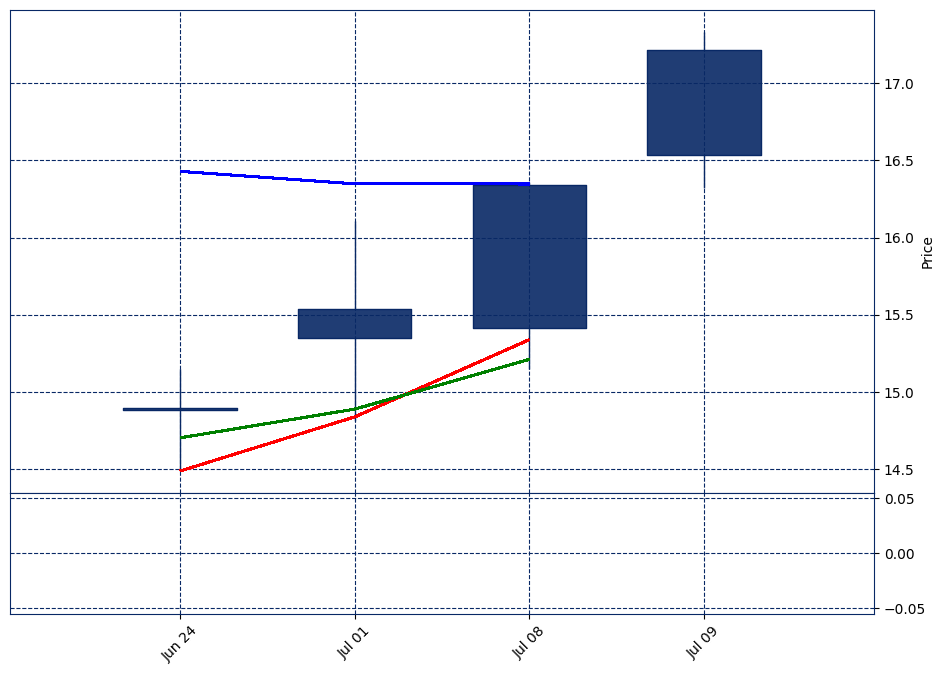

,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,CombinedVaderSentiment,Datetime,profit,trade
In,,,,,,,,,,,,,
8,14.882667,15.148667,14.490000,14.897333,14.489943,14.704548,16.428512,nn,nn,0.0,2019-06-24,0.5258,3
9,15.347333,16.104668,14.814667,15.540000,14.839962,14.890204,16.347738,nn,nn,0.0,2019-07-01,0.5258,3
10,15.416000,16.358667,15.152000,16.338667,15.339530,15.212084,16.346913,nn,nn,0.0,2019-07-08,0.5258,3
11,16.533333,17.330667,16.323999,17.212000,14.839962,14.890204,16.347738,17.330667,17.059133,0.0,2019-07-09,0.5258,3


In [39]:
#trade = 4
from plotting import PlotTrade

df = PlotTrade(trade=trade,trades_df=trades_df,window_size=window_size,entry_candle=entry_candle,
budget=budget,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
trade += 1
df


In [40]:
from final_evaluation import GetPerformanceReport

GetPerformanceReport = GetPerformanceReport()

GetPerformanceReport.fit(entry_candle=entry_candle,#"Current Open"
                        budget=10000,
                        window_size=window_size,
                        export_excel=True,
                        excel_path = excel_reports)

trades_df_final = GetPerformanceReport.transform(trades_df)
trades_df_final = trades_df_final.sort_values('Datetime', ascending=True)
trades_df_final.tail(5)

--------> GetPerformanceReport completed



,Open,High,Low,Close,EMA5,EMA8,EMA21,labels,prediction,CombinedVaderSentiment,Datetime,profit,trade,Entry,Performance
142,154.000000,155.250000,121.019997,123.150002,158.970499,173.955692,212.709109,nn,nn,0.000,2022-12-19,5.680000,36,nn,nn
143,117.500000,124.480003,108.239998,123.180000,176.880748,188.471603,221.665020,124.480003,174.936085,0.000,2022-12-20,5.680000,36,117.5,483.0
37,117.500000,124.480003,108.239998,123.180000,147.040333,162.672205,204.570099,nn,nn,0.000,2022-12-26,3.440002,10,nn,nn
38,118.470001,118.800003,101.809998,113.059998,135.713554,151.647270,196.250999,nn,nn,0.202,2023-01-02,3.440002,10,nn,nn
39,118.959999,125.949997,114.919998,122.400002,147.040333,162.672205,204.570099,125.949997,184.38114,0.000,2023-01-03,3.440002,10,118.959999,289.0


<b>Plot Chart With Labels and Predictions</b>

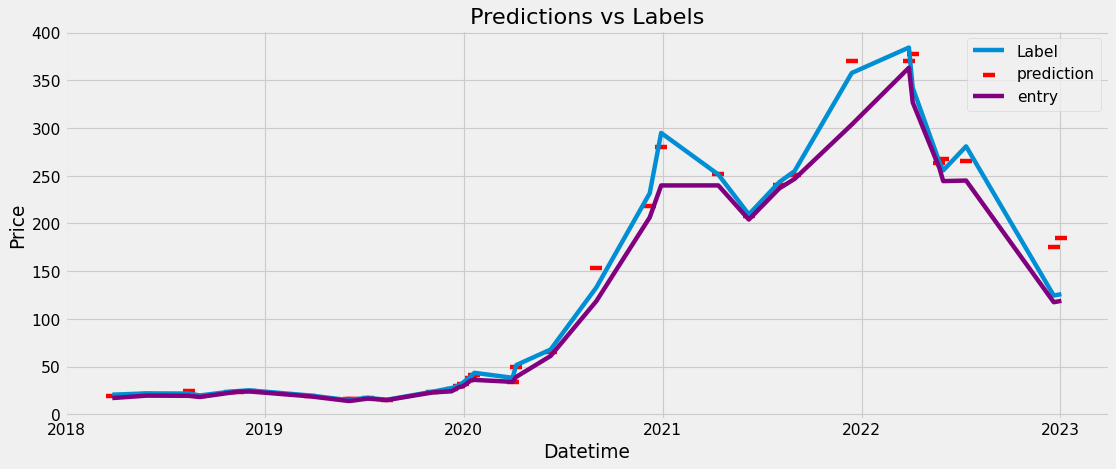

In [41]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
figure(figsize=(15, 6), dpi=80)

df_plot = trades_df_final[['Datetime','labels','prediction','Entry']]
df_plot = df_plot[df_plot.labels != 'nn']

x1 = df_plot['labels']
x2 = df_plot['prediction']
entry = df_plot['Entry']
y = df_plot['Datetime']

# plot lines
plt.plot(y, x1, label = "Label") #,s=200,marker='*'
plt.scatter(y, x2, label = "prediction",color='red', s=100,marker='_')
plt.plot(y, entry, label = "entry",color='purple')#,color='blue', s=100,marker=0
plt.xlabel('Datetime')
plt.ylabel('Price')
plt.title('Predictions vs Labels')
plt.legend()
plt.show()

<b>Export dataframe with all variables</b>

In [169]:
import shutil 
# ticker period eod_data_api api_key sentiment sentiment_type aggr_function formation_window 
# target_window split_ratio test_ratio validation_ratio condition 
# indicator1 indicator2 indicator3 window_size twitter start_date end_date batch_size_train batch_size_valid shuffle entry_candle
today = datetime.today().date()

shutil.copy(f'{model_name}', f'./Temp/{model_name_}')

variables_dict = \
{
'model_name':[model_name_],
'Date':[today],
'ticker':[ticker],
'period':[period],
'api_key':[api_key],
'sentiment':[sentiment],
'sentiment_type':[sentiment_type],
'aggr_function':[aggr_function],
'formation_window':[formation_window],
'target_window':[target_window],
'split_ratio':[split_ratio],
'test_ratio':[test_ratio],
'validation_ratio':[validation_ratio],
'condition':[condition],
'indicator1':[indicator1],
'indicator2':[indicator2],
'indicator3':[indicator3],
'window_size':[window_size],
'formation_window':[formation_window],
'twitter':[twitter],
'start_date':[start_date],
'end_date':[end_date],
'batch_size_train':[batch_size_train],
'batch_size_valid':[batch_size_valid],
'shuffle':[shuffle],
'entry_candle':[entry_candle],
'excel_reports':[excel_reports],
'acceptance':[acceptance],
'penalization':[penalization],
}

x_test.to_csv(f'./Temp/{ticker}_test_data.csv')
x_test_x.to_csv(f'./Temp/{ticker}_x_test_x.csv')
test_start = len(Dates)-x_test.shape[0]
Dates_test = Dates[test_start:]
Dates_test.to_csv(f'./Temp/{ticker}_dates_test.csv')
Dates.to_csv(f'./Temp/{ticker}_Dates.csv')
df = pd.DataFrame(variables_dict).transpose()
df.to_csv(f'./Temp/variables_df.csv')
df


,0
model_name,intc_model_2023-02-05_928.h5
Date,2023-02-05
ticker,intc
period,1wk
eod_data_api,False
api_key,631505e804ec58.42743136
sentiment,True
sentiment_type,CombinedVaderSentiment
aggr_function,median
formation_window,3


In [47]:
from final_evaluation import MakeSinglePrediction

#model_name = f'{saved_models}/{str.upper(ticker)}_{formation_window}_{target_window}_{window_size}_{split_ratio}_{period}_{sentiment}_{start_date}_{end_date}.h5'

MakeSinglePrediction = MakeSinglePrediction()
print('penalization: ',penalization)
print('penalization: ',acceptance)
fit_output = MakeSinglePrediction.fit(
                        model_name=model_name,
                        form_window=formation_window,
                        ticker=ticker,
                        start_date="2019-03-18",
                        end_date="2023-02-12",
                        interval=period, #1wk
                        progress=False,
                        condition=condition,
                        timeperiod1=indicator1,
                        timeperiod2=indicator2,
                        timeperiod3=indicator3,
                        debug=False,
                        budget=10000,
                        penalization=10,
                        acceptance=acceptance,
                        entry_candle='Current Close',
                        news_df=news_df,
                        sentiment=sentiment,
                        sentiment_type = sentiment_type,
                        sentiment_aggr = aggr_function)

#fit method outputs tuple, get only trade formation out of tuple
trade_formation = fit_output[1]
final_trade_formation = trade_formation.head(formation_window)
final_trade_formation
###IMPORTANT!!!!
#trade_formation dataframe must be checked before transformation, sometimes df pulled via yahoo finance 
# is shifted, and trade formation does not have entire formation in itself. in this case there must 
# be changed end_date in fit method

#final_trade_formation.tail()


penalization:  0
penalization:  0


,Date,Open,High,Low,Close,EMA5,EMA8,EMA21,CombinedVaderSentiment
0,2023-01-16,125.699997,136.679993,124.309998,133.419998,131.990468,142.541682,184.435702,0.155730
1,2023-01-23,135.869995,180.679993,134.270004,177.899994,147.293644,150.399084,183.841547,0.383464
2,2023-01-30,178.050003,199.000000,162.779999,189.979996,161.522428,159.194842,184.399587,0.000000



Ticker:  tsla
1/1 [==============================] - 1s 1s/step

Entry candle (Current Close)

Budget:  10000

Entry price:  196.89
Prediction:  190.19
Expected Market move:  -6.7
Expected Profit:  -341.8


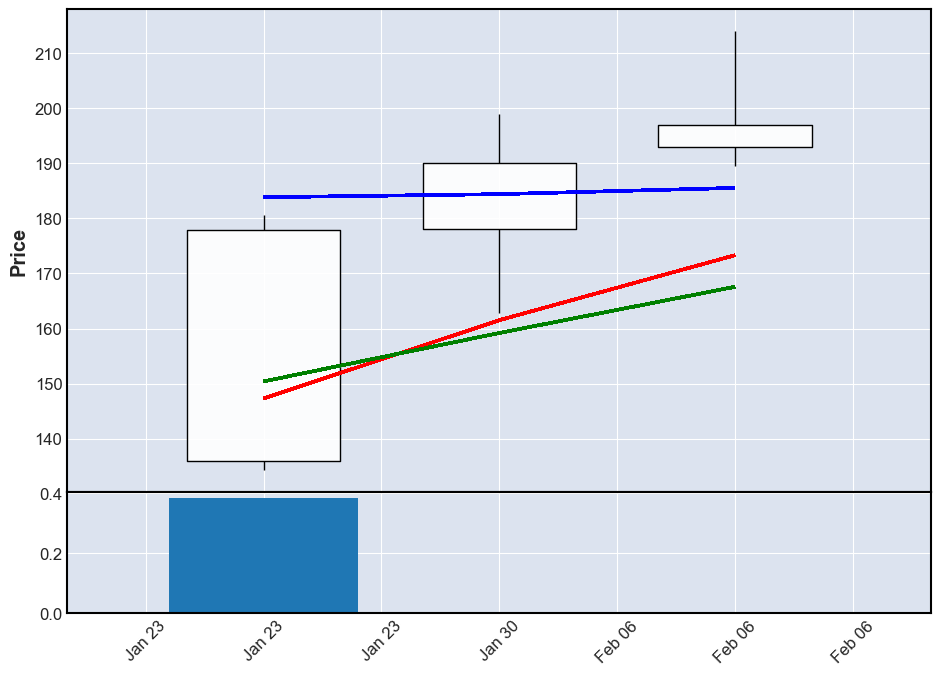

In [46]:
#Make prediction
MakeSinglePrediction.transform(final_trade_formation)

#PLot current chart and sentiment
from plotting import PlotCurrentFormation

PlotCurrentFormation(final_trade_formation,sentiment=sentiment,indicator1=indicator1,indicator2=indicator2,indicator3=indicator3)
